<a href="https://colab.research.google.com/github/qmeng222/CNN/blob/main/style-transfer/Me_Frida_Mosaic_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task:

---
Using the pretrained AlexNet model, transfer my headshot picture onto Frida's self-portrait in mosaic art.

In [451]:
import torchvision
import torchvision.transforms as T

from imageio import imread # to read content/style image from a url

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

# Import the AlexNet model & freeze all layers in the model to block any training:

In [452]:
# import the AlexNet model
alexnet = torchvision.models.alexnet(pretrained=True)

# freeze all layers to block any training
for p in alexnet.parameters():
    p.requires_grad = False

# switch to evaluation mode
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [453]:
# send the network to the GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

alexnet.to(device); # `;` suppresses the default output

cuda


# Import the ***content*** image and ***style*** image:

In [454]:
img4content = imread('https://media.licdn.com/dms/image/D5603AQEWb024B61Drg/profile-displayphoto-shrink_800_800/0/1692397684390?e=2147483647&v=beta&t=gia39pv-t3OlpwtHoQby10lNqemMmnrgXI2o9rcrzyk')
img4style   = imread('https://blog.mosaicartsupply.com/wp-content/uploads/2021/08/mosaic-frida-kahlo-detail-624x624.jpg')

# initialize the target image with random numbers (pure noise)
img4target = np.random.randint(low=0,high=255,size=img4content.shape,dtype=np.uint8) # unsigned 8-bit integer (non-negative)

print(img4content.shape)
print(img4style.shape)
print(img4target.shape)

<ipython-input-454-7c0046a12bfc>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4content = imread('https://media.licdn.com/dms/image/D5603AQEWb024B61Drg/profile-displayphoto-shrink_800_800/0/1692397684390?e=2147483647&v=beta&t=gia39pv-t3OlpwtHoQby10lNqemMmnrgXI2o9rcrzyk')
<ipython-input-454-7c0046a12bfc>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4style   = imread('https://blog.mosaicartsupply.com/wp-content/uploads/2021/08/mosaic-frida-kahlo-detail-624x624.jpg')


(768, 768, 3)
(624, 624, 3)
(768, 768, 3)


👆 These are high resolution images, which will make training take a long time.
   -> down-sample to 256x256

In [455]:
# create a transform object (a list of transform funcs)
Ts = T.Compose([ T.ToTensor(),  # [0, 250] -> [0, 1]
                 T.Resize(256), # resize the image to a width and height of 256 pixels
                 T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # specify mean and std for each color channel to normalize the image
               ])

# step1: apply the transformations to the images
# step2: "unsqueeze" to add an extra dimension to the tensor (3D -> 4D to match the input format required by the VGG model)
# step3: push to GPU
img4content = Ts( img4content ).unsqueeze(0).to(device)
img4style   = Ts( img4style   ).unsqueeze(0).to(device)
img4target  = Ts( img4target  ).unsqueeze(0).to(device)

print(img4content.shape)
print(img4style.shape)
print(img4target.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


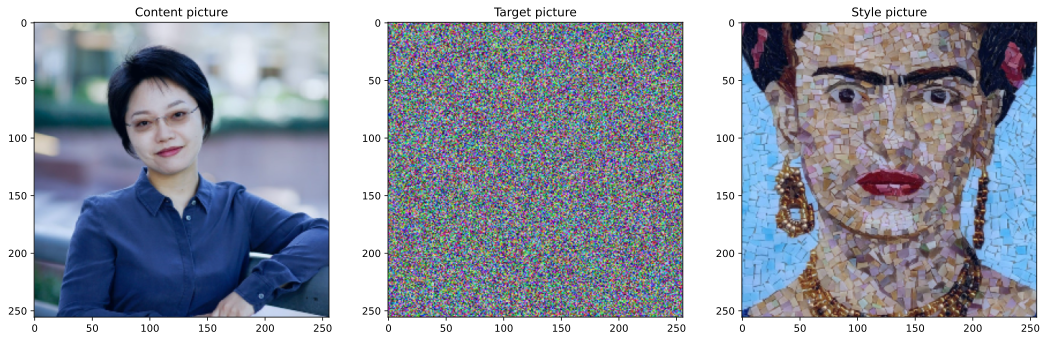

In [456]:
# let's visualize the "before" images:

fig,ax = plt.subplots(1,3,figsize=(18,6))

# step1: move the tensor from GPU to CPU
# step2: remove any dimensions with a size of 1
# step3: torch tensor -> np array
# step4: rearrange the dimensions of the array (because the `plt.imshow()` expects the color channels to be in the last dimension)
pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic)) # normalize
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img4target.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')

plt.show()

# Functions:

In [457]:
# a function to get the feature maps:

def getFeatureMapActs(img,net): # net: VGG

  # initialize feature maps as a list
  featuremaps = []
  featurenames = []

  convLayerIdx = 0 # init
  # loop through all layers in the "features" block
  for layernum in range(len(net.features)): # ref to the `features` block in `alexnet` at the very begninning
    # print("👀", layernum,net.features[layernum])

    # push the image through this layer
    img = net.features[layernum](img)
    # store the image if it's a convolutional layer
    if 'Conv2d' in str(net.features[layernum]):
      featuremaps.append( img )
      featurenames.append( 'ConvLayer_' + str(convLayerIdx) )
      convLayerIdx += 1

  return featuremaps,featurenames

In [458]:
# a function to compute gram matrix of the feature map:

def gram_matrix(F):

  _,chans,height,width = F.shape # do not assign a name to the first value returned by `M.shape`
  F = F.reshape(chans,height*width) # 3D feature cube -> 2D feature map (flattened 2D matrix)

  # compute the gram matrix
  gram = torch.mm(F,F.t()) / (chans*height*width) # mm: multiplication of the matrices
  return gram

# Get the feature maps and gram matrices from the content image:

In [459]:
# inspect the output of the `getFeatureMapActs` function:

featmaps,featnames = getFeatureMapActs(img4content,alexnet)

for i in range(len(featnames)):
  print('Feature map "%s" is size %s'%(featnames[i],(featmaps[i].shape)))

Feature map "ConvLayer_0" is size torch.Size([1, 64, 63, 63])
Feature map "ConvLayer_1" is size torch.Size([1, 192, 31, 31])
Feature map "ConvLayer_2" is size torch.Size([1, 384, 15, 15])
Feature map "ConvLayer_3" is size torch.Size([1, 256, 15, 15])
Feature map "ConvLayer_4" is size torch.Size([1, 256, 15, 15])


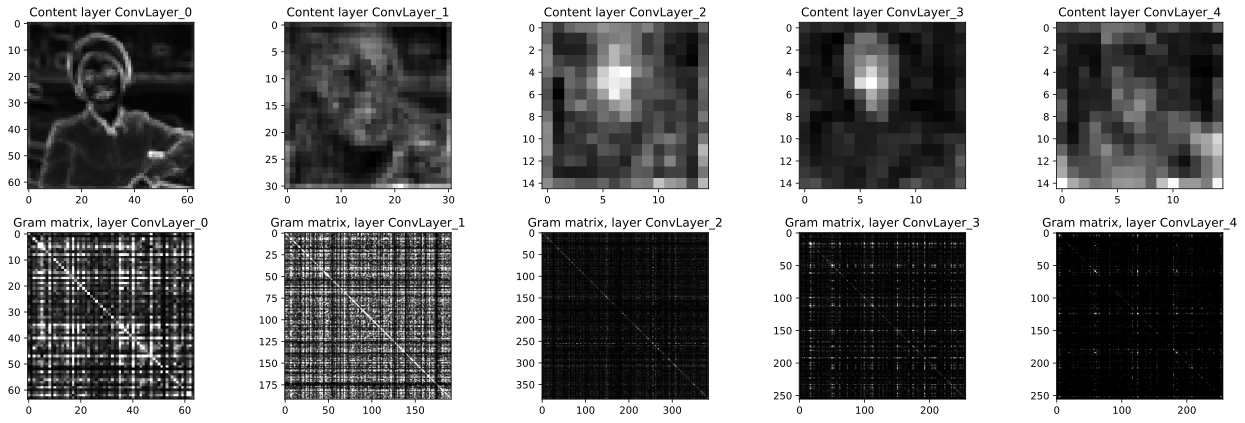

In [460]:
# visualize the "content" image:

contentFeatureMaps,contentFeatureNames = getFeatureMapActs(img4content,alexnet)

fig,axs = plt.subplots(2,5,figsize=(18,6))

for i in range(5): # the first 5 layers
  # average over all feature maps from this layer & normalize
  pic = np.mean( contentFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='gray')
  axs[0,i].set_title('Content layer ' + str(contentFeatureNames[i]))

  # get the gram matrix
  pic = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='gray',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(contentFeatureNames[i]))

plt.tight_layout()
plt.show()

👆 As we get to dedper convolutional layers (only showing the first five layers here), the feature maps're getting fuzzier and fuzzier.

So there are different features that are being extracted from these images, from the content image at a different level of resolution.

# Get the feature maps and gram matrices from the style image:

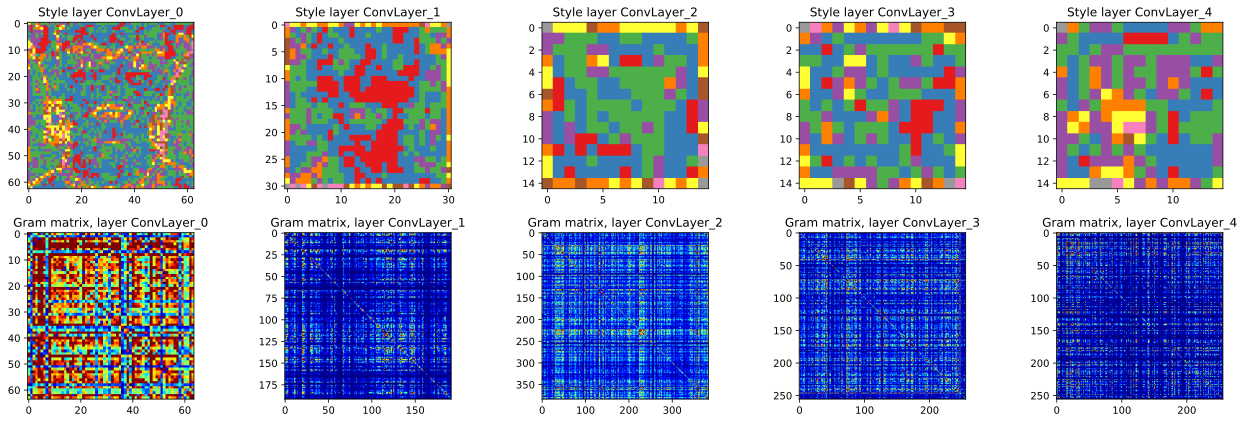

In [461]:
styleFeatureMaps,styleFeatureNames = getFeatureMapActs(img4style,alexnet)

fig,axs = plt.subplots(2,5,figsize=(18,6))

for i in range(5):
  # average over all feature maps from this layer & normalize
  pic = np.mean( styleFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='Set1')
  axs[0,i].set_title('Style layer ' + str(styleFeatureNames[i]))

  # get the gram matrix
  pic = gram_matrix(styleFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='jet',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(styleFeatureNames[i]))

plt.tight_layout()
plt.show()

# Style transfer:

In [462]:
# specify which layers to use (arbitrary choices)
layers4content = [ 'ConvLayer_0']#,'ConvLayer_1','ConvLayer_2','ConvLayer_3' ]
layers4style   = [ 'ConvLayer_0','ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4' ]
weights4style  = [      1       ,      .8      ,     .6      ,    .4      ,      .2      ] # style contributes less as we go deeper into the network

In [463]:
# make a copy of the target image and push to GPU
target = img4content.clone()
target.requires_grad = True
target = target.to(device)
styleScaling = 5e4

# number of epochs to train
numepochs = 1500

# optimizer for backprop
optimizer = torch.optim.RMSprop([target],lr=.001)


for epochi in range(numepochs):

  # extract the target feature maps
  targetFeatureMaps,targetFeatureNames = getFeatureMapActs(target,alexnet)


  # initialize the individual loss components
  styleLoss = 0
  contentLoss = 0

  # loop over layers
  for layeri in range(len(targetFeatureNames)):


    # compute the content loss
    if targetFeatureNames[layeri] in layers4content:
      contentLoss += torch.mean( (targetFeatureMaps[layeri]-contentFeatureMaps[layeri])**2 )


    # compute the style loss
    if targetFeatureNames[layeri] in layers4style:

      # Gram matrices
      Gtarget = gram_matrix(targetFeatureMaps[layeri])
      Gstyle  = gram_matrix(styleFeatureMaps[layeri])

      # compute their loss (de-weighted with increasing depth)
      styleLoss += torch.mean( (Gtarget-Gstyle)**2 ) * weights4style[layers4style.index(targetFeatureNames[layeri])]


  # combined loss
  combiloss = styleScaling*styleLoss + contentLoss

  # finally ready for backprop!
  optimizer.zero_grad()
  combiloss.backward()
  optimizer.step()

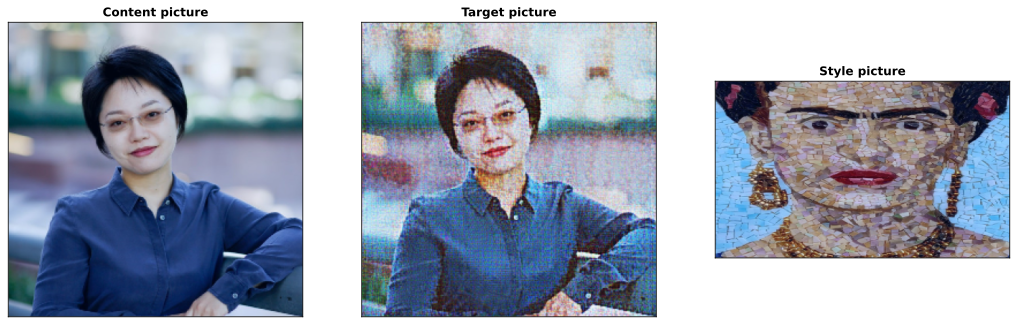

In [464]:
# let's visualize the "after" images:

fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(pic)
ax[1].set_title('Target picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()